# Question 2: Which bases generate the highest total revenue, and how does that rank change by year and by branch?

## Objective

Identify which military bases contributed the most slot-machine revenue from FY 2020–FY 2024, and examine how their ranking evolved by year and by service branch (Army, Navy, USMC).

In [8]:
# =======================================================
# DS701 — Base Revenue Ranking & Trend (FY20–FY24)
# Source columns: Service, Category, Region, Base, Location, Month, Year, Amount
# =======================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gdown
from matplotlib.ticker import ScalarFormatter

# ------------------- Download CSV via gdown -------------------
!pip install gdown

FILE_ID = "1k15B6aBh9ri74ZZXCxcL0jyemEUirn6o"
CSV_PATH = "District_Revenue_FY20-FY24_with_lat_lon_clean.csv"
url = f"https://drive.google.com/uc?id={FILE_ID}"

gdown.download(url, CSV_PATH, quiet=False)

# ------------------- Parameters -------------------
TOP_N = 10   # number of top bases to include
YEAR_MIN, YEAR_MAX = 2020, 2024  # fiscal year range

# ------------------- Load & Clean Data -------------------
df = pd.read_csv(CSV_PATH)

df['Base'] = df['Base'].replace('Camp Hanson USMC', 'Camp Hansen USMC')

df['Base'] = df['Base'].replace(
    to_replace=r'(?i)^\s*hohenfels[\s\-–—]*\s*$',
    value='Hohenfels',
    regex=True
)

# Rename columns (ensure they match your file exactly)
df = df.rename(columns={
    'Service': 'Service',
    'Category': 'Category',
    'Region': 'Region',
    'Base': 'Base',
    'Location': 'Location',
    'Month': 'Month',
    'Year': 'Year',
    'Amount': 'Amount'
})

# Clean Amount column (remove $, commas, parentheses, etc.)
df['Amount'] = (
    df['Amount'].astype(str)
                .str.replace(r'[\$,()]', '', regex=True)
                .str.replace(',', '', regex=False)
)
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce').fillna(0)

# Normalize year (remove "FY", convert to int) and filter range
def _to_year(x):
    s = str(x)
    s = s.replace('FY', '').replace('fy', '').strip()
    try:
        return int(float(s))
    except:
        return np.nan

df['Year'] = df['Year'].apply(_to_year)
df = df.dropna(subset=['Year'])
df['Year'] = df['Year'].astype(int)
df = df[(df['Year'] >= YEAR_MIN) & (df['Year'] <= YEAR_MAX)]

# ------------------- Aggregate Base × Year × Service -------------------
for col in ['Service','Region','Base']:
    df[col] = df[col].astype(str).str.strip()

agg = (
    df.groupby(['Year', 'Service', 'Region', 'Base'], as_index=False)['Amount']
      .sum()
      .rename(columns={'Amount': 'Total_Revenue'})
      .sort_values(['Year', 'Total_Revenue'], ascending=[True, False])
)

# ------------------- Compute Top N Bases Each Year -------------------
top_yearly = (
    agg.groupby('Year', group_keys=False)
       .apply(lambda x: x.nlargest(TOP_N, 'Total_Revenue'))
       .reset_index(drop=True)
)

print("\n==== Compute Total Revenue and Top 10 ====")
print(top_yearly.head(TOP_N))

# ------------------- Rank Bases by Year and by Service -------------------
top_yearly['Rank_All'] = (
    top_yearly.groupby('Year')['Total_Revenue']
              .rank(method='first', ascending=False)
)
top_yearly['Rank_ByService'] = (
    top_yearly.groupby(['Year', 'Service'])['Total_Revenue']
              .rank(method='first', ascending=False)
)

print("\n==== Rank Bases by Year and by Service ====")
print(top_yearly[['Year', 'Service', 'Base', 'Total_Revenue', 'Rank_All', 'Rank_ByService']].head(12))



Downloading...
From: https://drive.google.com/uc?id=1k15B6aBh9ri74ZZXCxcL0jyemEUirn6o
To: /content/District_Revenue_FY20-FY24_with_lat_lon_clean.csv
100%|██████████| 886k/886k [00:00<00:00, 10.5MB/s]



==== Compute Total Revenue and Top 10 ====
   Year Service  Region                       Base  Total_Revenue
0  2020    USMC   Japan  Camp Butler / Foster USMC       13791192
1  2020    Army   Korea             Camp Humphreys       12628040
2  2020    Army   Korea     AFRC Dragon Hill Lodge        6400848
3  2020    Navy   Japan              Yokosuka Navy        5556460
4  2020    Army   Korea                      Daegu        3098947
5  2020    Navy   Japan                Sasebo Navy        3045734
6  2020    Army  Europe             Kaiserslautern        3027571
7  2020    USMC   Japan               Iwakuni USMC        2980756
8  2020    Army   Korea              Casey / Hovey        2745411
9  2020    Navy   Japan                Atsugi Navy        2229991

==== Rank Bases by Year and by Service ====
    Year Service                       Base  Total_Revenue  Rank_All  \
0   2020    USMC  Camp Butler / Foster USMC       13791192       1.0   
1   2020    Army             Camp Humphre

/tmp/ipython-input-1428852705.py:84: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(TOP_N, 'Total_Revenue'))


## Figure １. Bar Chart — Total Revenue of Top 10 Bases (FY2020–FY2024)
This bar chart summarizes cumulative revenue for the top ten bases over the five-year period.
Camp Butler / Foster (USMC) leads with approximately 70.6M dollars, followed by Camp Humphreys (Army) at 60.9M dollars and Yokosuka Navy (Japan) at 36.5M dollars.
The next group includes AFRC Dragon Hill Lodge (24.3M) and Sasebo Navy (16.2M).
Rounding out the list are Iwakuni USMC, Kaiserslautern, Wiesbaden, Casey/Hovey, and Daegu, each contributing between $12–15M.
Together, these ten installations account for the majority of ARMP global revenue, with Asia-based locations alone representing over 70% of total earnings.

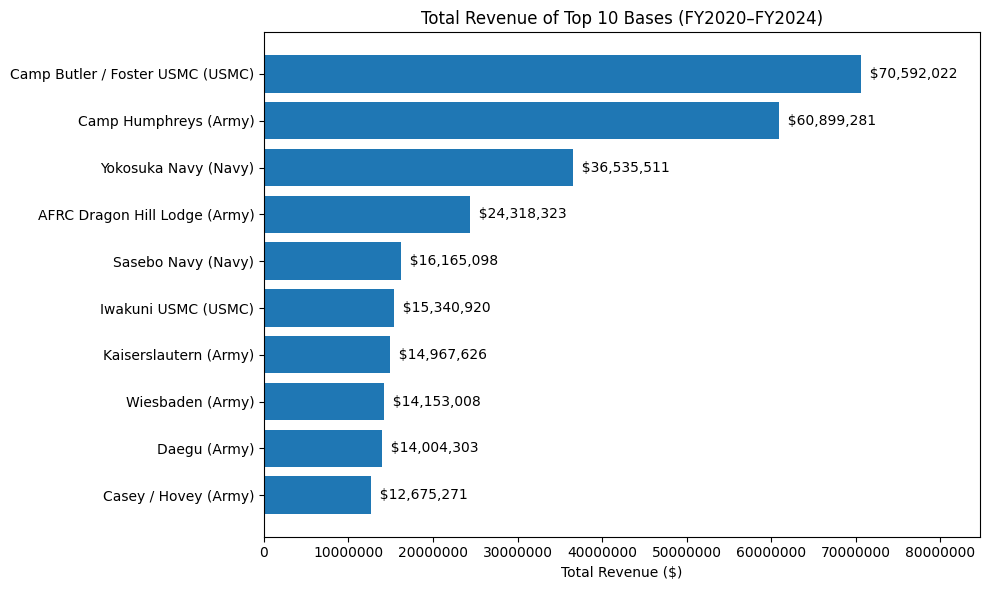

In [13]:
# ------------------- Bar Chart – Total Revenue (All Years Combined) -------------------
total_overall = (
    agg.groupby(['Base', 'Service'], as_index=False)['Total_Revenue']
       .sum()
       .sort_values('Total_Revenue', ascending=False)
)
total_overall_top = total_overall.head(TOP_N)

plt.figure(figsize=(10, 6))
y_pos = np.arange(len(total_overall_top))
labels = [f"{b} ({s})" for b, s in zip(total_overall_top['Base'], total_overall_top['Service'])]
plt.barh(y_pos, total_overall_top['Total_Revenue'])
plt.gca().invert_yaxis()
plt.gca().margins(x=0.2)
plt.ticklabel_format(axis='x', style='plain')
plt.yticks(y_pos, labels)
plt.xlabel('Total Revenue ($)')
plt.title(f"Total Revenue of Top {TOP_N} Bases (FY{YEAR_MIN}–FY{YEAR_MAX})")


# Add value labels
for i, v in enumerate(total_overall_top['Total_Revenue']):
    plt.text(v, i, f"  ${v:,.0f}", va='center')

plt.tight_layout()
plt.show()

## Figure 2. Annual Revenue Trend of Top Bases — Top 10 per Year (FY2020–FY2024)

This chart shows the year-over-year revenue trend for the ten highest-grossing bases from FY2020 to FY2024.
Camp Butler / Foster (USMC – Japan) and Camp Humphreys (Army – Korea) stand out clearly, both peaking in FY2023 at around $18M and $15M, respectively, before a noticeable decline in FY2024 (due to partial data coverage).
Yokosuka Navy (Japan) ranks third with steady growth through FY2023, while mid-tier bases such as AFRC Dragon Hill Lodge, Daegu, Kaiserslautern, and Wiesbaden maintain moderate but stable revenue levels ($3–6M).
Overall, the Asia-Pacific region (Japan and Korea) dominates the top ten, reflecting high facility utilization and strong MWR demand across forward-deployed locations.

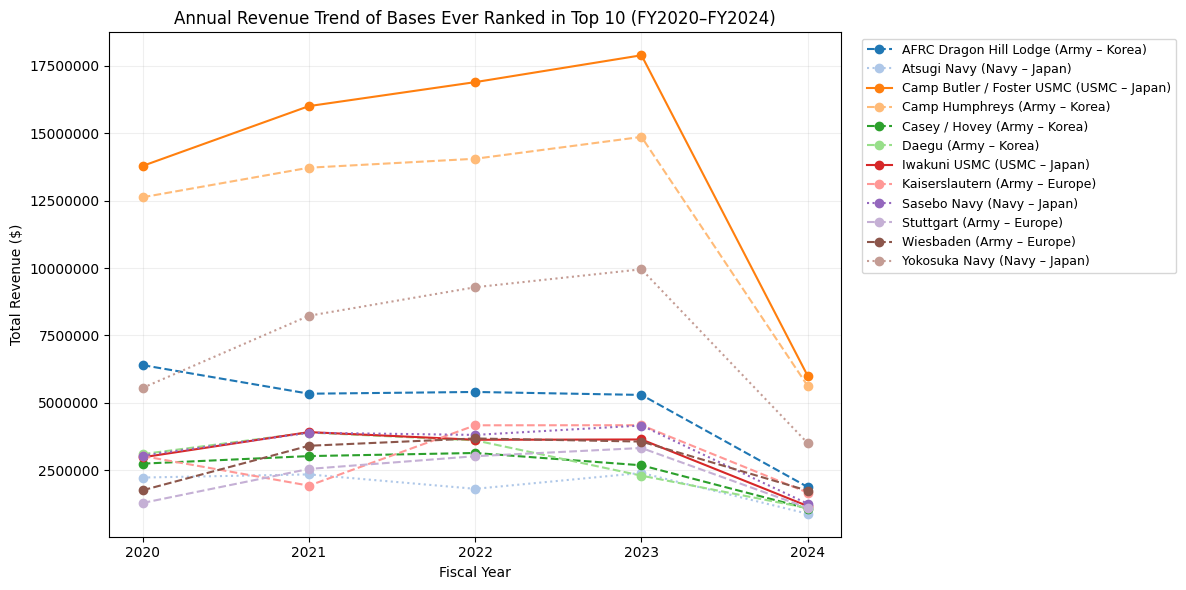

In [19]:
# ------------------- Line Chart – Annual Revenue Trend -------------------

# 1. Collect all bases that ever appeared in the Top N for any year
top_bases_set = set(top_yearly['Base'].unique())
trend_df = agg[agg['Base'].isin(top_bases_set)].copy()

plt.figure(figsize=(12, 6))

# 2. Assign different line styles per Service
services = trend_df['Service'].unique().tolist()
linestyles = ['-', '--', ':', '-.']
ls_map = {svc: linestyles[i % len(linestyles)] for i, svc in enumerate(services)}

# 3. Assign a unique color to each Base using the tab20 colormap
bases = sorted(top_bases_set)                 # fixed order → stable colors
colors = plt.cm.tab20.colors                  # 20 distinct colors
color_map = {base: colors[i % len(colors)] for i, base in enumerate(bases)}

# 4. Plot each Base: color by Base, line style by Service
for base, g in trend_df.groupby('Base'):
    service = g['Service'].iloc[0]
    region = g['Region'].iloc[0] if 'Region' in g.columns else 'Unknown'

    plt.plot(
        g['Year'],
        g['Total_Revenue'],
        marker='o',
        linestyle=ls_map.get(service, '-'),
        color=color_map[base],
        label=f"{base} ({service} – {region})"
    )

# === X-axis (Fiscal Years) ===
fiscal_years = list(range(YEAR_MIN, YEAR_MAX + 1))
plt.xticks(fiscal_years, [str(y) for y in fiscal_years])
plt.ticklabel_format(axis='y', style='plain')

plt.title(f"Annual Revenue Trend of Bases Ever Ranked in Top {TOP_N} (FY{YEAR_MIN}–FY{YEAR_MAX})")
plt.xlabel("Fiscal Year")
plt.ylabel("Total Revenue ($)")
plt.grid(True, alpha=0.2)



plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()


## Figures 3. Branch-Level Revenue Trends (FY2020–FY2024)
Across all three service branches, consistent patterns emerge in both regional concentration and leadership stability.
For the Army, Camp Humphreys (Korea) remains the undisputed top performer, steadily increasing to nearly 15 million dollars by FY2023, while Dragon Hill Lodge, Kaiserslautern, and Wiesbaden show moderate but steady earnings.
Within the Navy, Yokosuka (Japan) dominates branch revenues—doubling between FY2020 and FY2023—followed by Sasebo and Atsugi, with European bases such as Naples and Rota trailing far behind.
For the Marine Corps, Camp Butler / Foster (Japan) far surpasses every other base, peaking around 18 million dollars in FY2023 and accounting for the majority of Marine Corps slot-machine revenue, while Iwakuni, Hansen, and Kinser contribute smaller, stable figures.
Taken together, these trends show that Japan and Korea are the revenue core for all branches, with each service anchored by one dominant installation; the synchronized FY2024 downturn reflects incomplete fiscal data rather than operational decline.


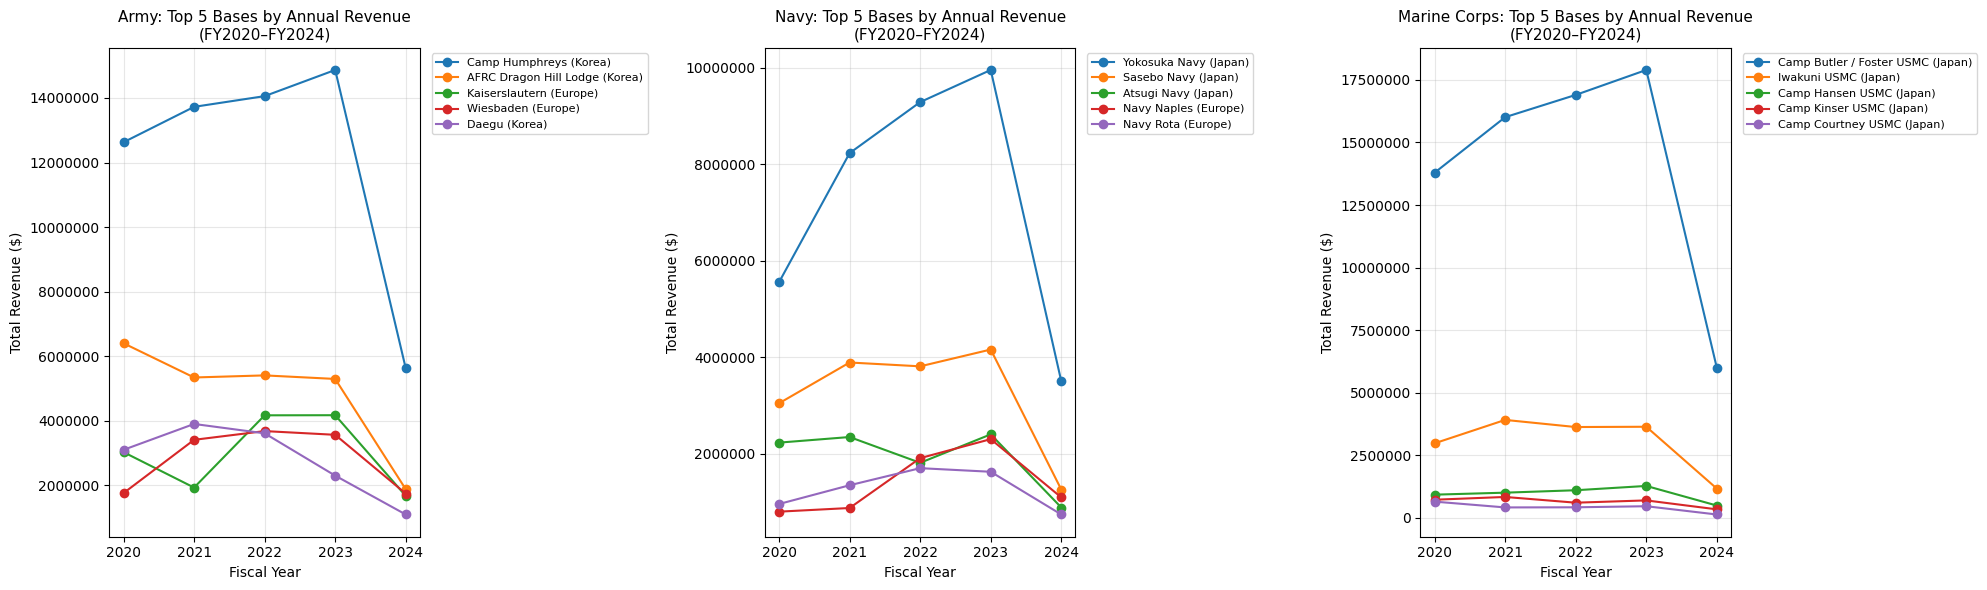

You can adjust TOP_N or YEAR range to customize the scope.


In [12]:
# =======================================================
# Three Line Charts by Service (Army / Navy / USMC)
# X-axis: Fiscal Year (2020–2024)
# Y-axis: Annual revenue ($)
# Each chart shows the Top 5 bases (by cumulative FY revenue within that service)
# =======================================================

# Normalize Service labels
service_map = {
    'USMC': 'Marine Corps',
    'Marine': 'Marine Corps',
    'Marine corps': 'Marine Corps',
    'marine corps': 'Marine Corps',
    'marine': 'Marine Corps',
}
agg_norm = agg.copy()
agg_norm['Service'] = agg_norm['Service'].replace(service_map)

target_services = ['Army', 'Navy', 'Marine Corps']
year_min, year_max = YEAR_MIN, YEAR_MAX
top_k = 5
all_years = list(range(year_min, year_max + 1))

# Create 3 horizontal subplots (no shared axes)
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=False, sharey=False)

for i, svc in enumerate(target_services):
    ax = axes[i]
    svc_df = agg_norm[agg_norm['Service'].str.lower() == svc.lower()].copy()
    if svc_df.empty:
        ax.set_title(f"{svc} — No Data")
        continue

    # Filter for the selected years
    svc_period = svc_df[(svc_df['Year'] >= year_min) & (svc_df['Year'] <= year_max)]

    # Get top 5 bases by cumulative revenue
    top_bases = (
        svc_period.groupby('Base', as_index=False)['Total_Revenue']
        .sum()
        .sort_values('Total_Revenue', ascending=False)
        .head(top_k)['Base']
        .tolist()
    )

    plot_df = svc_period[svc_period['Base'].isin(top_bases)].copy()

    # Plot each base as a separate line
    for base in top_bases:
        g = plot_df[plot_df['Base'] == base]
        region = g['Region'].iloc[0] if 'Region' in g.columns else 'Unknown'
        g = g.set_index('Year')['Total_Revenue'].reindex(all_years, fill_value=0)
        ax.plot(all_years, g.values, marker='o', label=f"{base} ({region})")

    ax.set_title(f"{svc}: Top {top_k} Bases by Annual Revenue\n(FY{year_min}–FY{year_max})", fontsize=11)
    ax.set_xlabel("Fiscal Year")
    ax.set_ylabel("Total Revenue ($)")
    ax.set_xticks(all_years)
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(style='plain', axis='y')
    ax.legend(fontsize=8, bbox_to_anchor=(1.02, 1), loc="upper left")

# Adjust layout
plt.tight_layout()
plt.show()

print("You can adjust TOP_N or YEAR range to customize the scope.")


## Key Takeaways

Geographic dominance: Far East (Korea + Japan) bases contribute > 70 % of total ARMP slot-machine revenue.

Army leadership: Army bases collectively generate nearly 60 % of global revenue.

Stability: Top bases show modest year-to-year fluctuations, suggesting stable demand.

Emerging growth: Europe bases such as Kaiserslautern and Wiesbaden showed rising performance post-COVID (FY22-24).